In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

print(tf.__version__)


2.7.0


In [2]:
# get X and Y
# snoring range of the user, respiration rate, body temperature, limb movement rate, blood oxygen levels, eye movement, number of hours of sleep, heart rate and Stress Levels (0- low/normal, 1 – medium low, 2- medium, 3-medium high, 4 -high)
data_setframe = pd.read_csv(filepath_or_buffer="./human_stresslevel_data/SaYoPillow.csv",header=[0,1,2,3,4,5,6,7,8])

# rename column name
data_setframe.columns = ['snoring_rate','respiration_rate','temperature','limb_movement','blood_oxygen','eye_movement','sleeping_hour','heart_rate','stress_level']

# get X and Y
X_data = data_setframe[['snoring_rate','respiration_rate','temperature','limb_movement','blood_oxygen','eye_movement','sleeping_hour','heart_rate']]
Y_data = data_setframe[['stress_level']]


In [3]:
#normalizse
X_data = normalize(X_data,norm='l2')

In [4]:
# split training and test set
x_train,x_test,y_train,y_test = train_test_split(X_data,Y_data,test_size=0.2,random_state=1)

x_train = tf.convert_to_tensor(x_train,dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test,dtype=tf.float32)


2022-05-01 13:52:40.243853: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# one hot matrix
def oneHotMatrix(labels,depth):
    one_hot = tf.one_hot(labels,depth,on_value = 1.0, off_value = 0.0,axis=1)
    one_hot = one_hot[0,:,:]
    return one_hot
    

In [6]:
# initialize parameter
def initializeParameters():
    initializer = tf.keras.initializers.GlorotNormal(seed=1)
    
    parameters = {}
    parameters['W1'] = tf.Variable(initializer(shape=(4,8)))
    parameters['b1'] = tf.Variable(initializer(shape=(4,1)))
    parameters['W2'] = tf.Variable(initializer(shape=(4,4)))
    parameters['b2'] = tf.Variable(initializer(shape=(4,1)))
    parameters['W3'] = tf.Variable(initializer(shape=(6,4)))
    parameters['b3'] = tf.Variable(initializer(shape=(6,1)))
    parameters['W4'] = tf.Variable(initializer(shape=(5,6)))
    parameters['b4'] = tf.Variable(initializer(shape=(5,1)))
        
    return parameters

In [7]:
# forward propagation
def forwardPropagation(parameters,x_input):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    
    # Linera -> Relu -> Linear -> relu
    Z1 = tf.math.add(tf.linalg.matmul(W1,x_input),b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2,A1),b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.math.add(tf.linalg.matmul(W3,A2),b3)
    A3 = tf.keras.activations.relu(Z3)
    Z4 = tf.math.add(tf.linalg.matmul(W4,A3),b4)
    
    return Z4

In [8]:
# cost function categarical cross entropy (softmax and one hot encoded matrix)
def costFucntion(logits,labels):
    cost = tf.math.reduce_mean(tf.keras.metrics.categorical_crossentropy(tf.transpose(labels),tf.transpose(logits), from_logits= True))
    
    return cost
        

In [9]:
# create minibatch (only for reference not used in this code)
def minibatch(batch_size,zipped_data):
    
    minibatch = []
    start_value = 0
    zipped_data= list(zipped_data)
    total_samples = len(list(zipped_data))
    x,y = zip(*zipped_data)
    input_batch = []
    output_batch = []
    while batch_size <= total_samples:
        input_batch.append(x[start_value:batch_size])
        output_batch.append(y[start_value:batch_size])
        start_value = batch_size
        batch_size = batch_size + batch_size 
    
    if batch_size < total_samples:
        batch_size = batch_size + total_samples-batch_size
        minibatch.append(zip(x[start_value:batch_size],y[start_value:batch_size]))
    
    minibatch = zip(input_batch,output_batch)
    
    return minibatch


In [10]:
# define stochastic gradient descent model
def model(learning_rate,epochs,train_input,train_output,test_input,test_output,minibatch_size):
    
    parameters = initializeParameters()
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    
    
    train_samples,_ = train_input.shape
    test_samples,_ = test_input.shape
    
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # The CategoricalAccuracy will track the accuracy for this multiclass problem
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    train_output = tf.transpose(oneHotMatrix(tf.transpose(train_output),depth=5))
    test_output = tf.transpose(oneHotMatrix(tf.transpose(test_output),depth=5))
    

    train_accuracy_array = []
    test_accuracy_array = []
    train_cost = []
    
    # traing for data set for given number of epoch 
    for epoch in range(0,epochs):
        
        train_accuracy.reset_states()
        with tf.GradientTape() as tape:

            # predict
            Z4 = forwardPropagation(parameters,tf.transpose(train_input))

            # cost
            train_epoch_cost =  costFucntion(Z4,tf.transpose(train_output))

        #accuracy
        train_accuracy.update_state(tf.transpose(Z4),train_output)

        #parameters
        trainable_parameters =  [W1,b1,W2,b2,W3,b3,W4,b4]
        # gradients
        grads = tape.gradient(train_epoch_cost,trainable_parameters)
        # optimize
        adam_optimizer.apply_gradients(zip(grads,trainable_parameters))

        train_cost.append(train_epoch_cost)
        train_accuracy_array.append(train_accuracy.result())

        if epoch % 10 == 0 :
            print(f"Epoch : {epoch}")

            print(f'Cost : {train_epoch_cost}, Training accuracy : {train_accuracy.result()}')
            
            test_accuracy.reset_states()
            #calculate test accuracy
            test_Z4 = forwardPropagation(parameters,tf.transpose(test_input))
            test_accuracy.update_state(tf.transpose(test_Z4),test_output)
            test_accuracy_array.append(test_accuracy.result())
            print(f'Test accuracy : {test_accuracy.result()}')
    
    return parameters,train_cost,train_accuracy_array,test_accuracy_array

In [11]:
parameters,train_cost, train_accuracy_array,test_accuracy_array = model(learning_rate=0.01,epochs=150,train_input=x_train,train_output=y_train,test_input=x_test,test_output=y_test,minibatch_size =5)

Epoch : 0
Cost : 1.7153406143188477, Training accuracy : 0.2012072503566742
Test accuracy : 0.20800000429153442
Epoch : 10
Cost : 1.611415982246399, Training accuracy : 0.2012072503566742
Test accuracy : 0.20800000429153442
Epoch : 20
Cost : 1.5746420621871948, Training accuracy : 0.20321930944919586
Test accuracy : 0.17599999904632568
Epoch : 30
Cost : 1.5441125631332397, Training accuracy : 0.3661971688270569
Test accuracy : 0.3440000116825104
Epoch : 40
Cost : 1.496460199356079, Training accuracy : 0.40442654490470886
Test accuracy : 0.36000001430511475
Epoch : 50
Cost : 1.419928789138794, Training accuracy : 0.4245472848415375
Test accuracy : 0.3840000033378601
Epoch : 60
Cost : 1.314367651939392, Training accuracy : 0.44668006896972656
Test accuracy : 0.4399999976158142
Epoch : 70
Cost : 1.1844265460968018, Training accuracy : 0.48893359303474426
Test accuracy : 0.42399999499320984
Epoch : 80
Cost : 1.068603515625, Training accuracy : 0.5130784511566162
Test accuracy : 0.488000005

In [12]:
# print(f'parameters {parameters}')

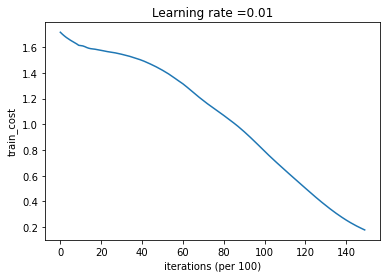

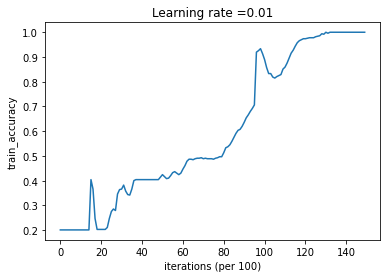

In [13]:
plt.plot(np.squeeze(train_cost))
plt.ylabel('train_cost')
plt.xlabel('iterations (per 100)')
plt.title("Learning rate =" + str(0.01))
plt.show()

plt.plot(np.squeeze(train_accuracy_array))
plt.ylabel('train_accuracy')
plt.xlabel('iterations (per 100)')
plt.title("Learning rate =" + str(0.01))
plt.show()

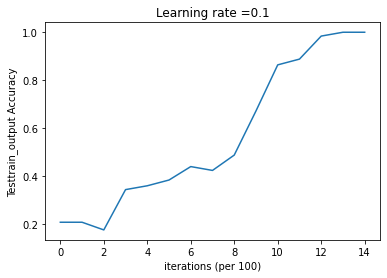

In [14]:
# Plot the graph fortrain accuracy
plt.plot(np.squeeze(test_accuracy_array))
plt.ylabel('Testtrain_output Accuracy')
plt.xlabel('iterations (per 100)')
plt.title("Learning rate =" + str(0.1))
plt.show()